In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline

# # Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# # Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# preprocessing
from sklearn.model_selection import GridSearchCV, KFold
# # for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
# # Models
from sklearn.linear_model import LogisticRegression

# # Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# # tunning hyperparamters model
import optuna

from sklearn.impute import SimpleImputer

In [129]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### **Предварительные графические зависимости**

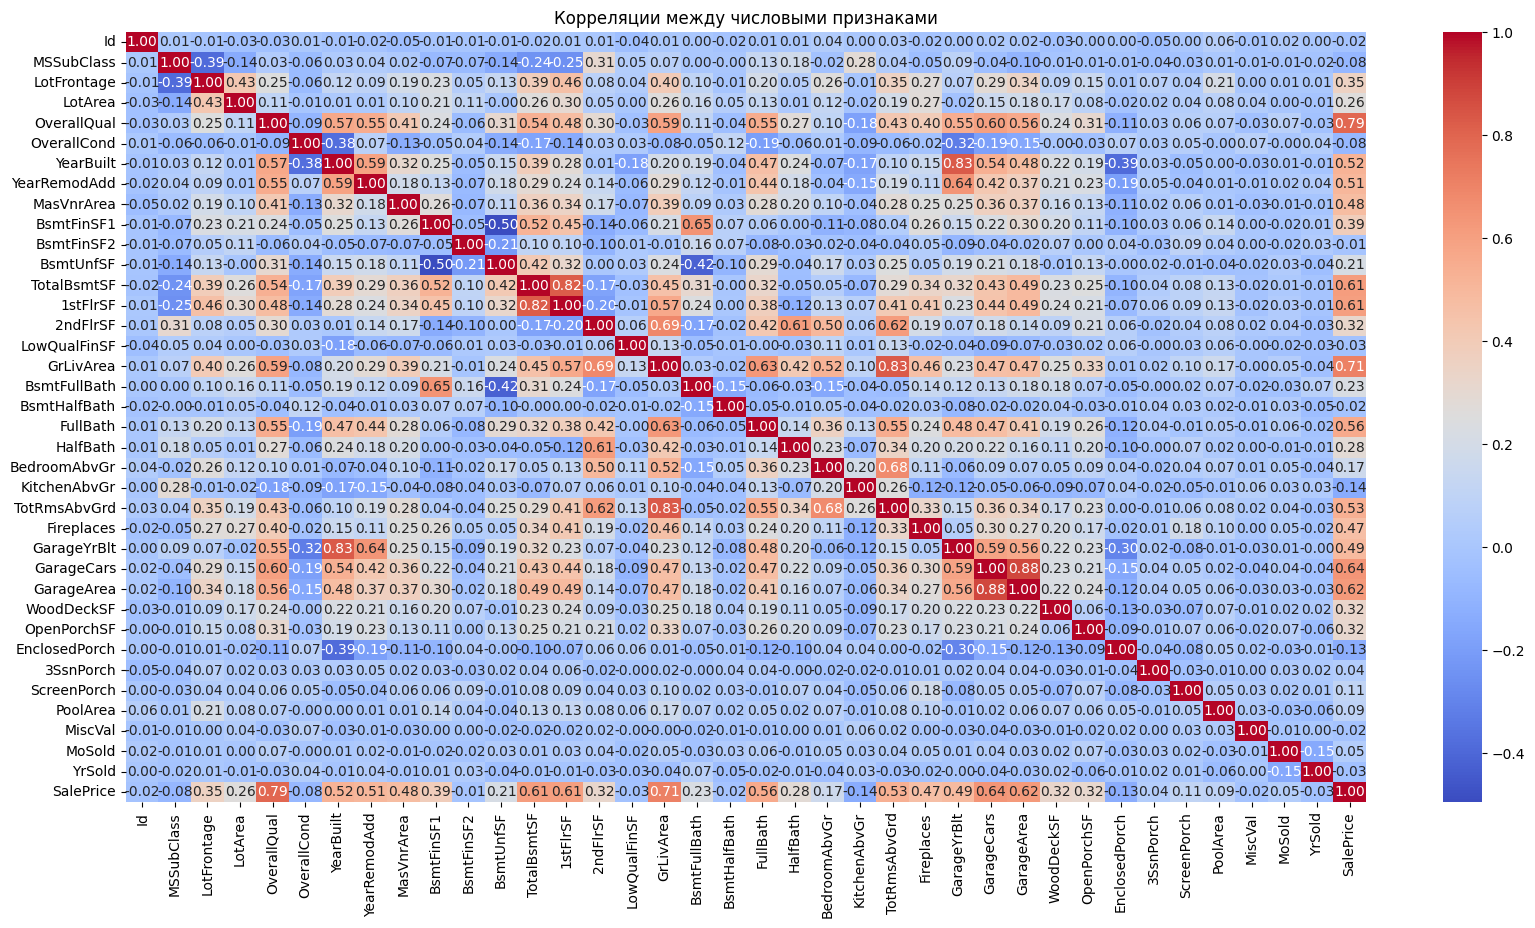

In [130]:
# выбираем только числовые колонки
df_matr = df_train.select_dtypes(include=['float64', 'int64'])

# строим корреляционную матрицу
corr = df_matr.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляции между числовыми признаками")
plt.show()


In [131]:
# достаем все признаки, где коэффициент Пирсона для таргета больше 0.32
mask = abs(corr['SalePrice'] > 0.32)

features = corr[mask].index.drop('SalePrice')

import_feature_1 = sorted(features.to_list())

print(f'Исходя из тепловой карты кажутся наиболее значимыми следующие признаки: {", ".join(import_feature_1)}') 
import_feature_1

Исходя из тепловой карты кажутся наиболее значимыми следующие признаки: 1stFlrSF, BsmtFinSF1, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, LotFrontage, MasVnrArea, OverallQual, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd


['1stFlrSF',
 'BsmtFinSF1',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'LotFrontage',
 'MasVnrArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

## **Preproccesing**

In [132]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [133]:
# отделяем общий тренировочный датасет на признаки для обучения и таргет для обучения
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [134]:
# === ШАГ 1: Определяем типы колонок ДО всех преобразований ===
# Получаем ВСЕ колонки из исходного X_train
all_columns = X_train.columns.tolist()

# Колонки для удаления
columns_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

# Списки для специальных обработок (из вашего my_imputer)
mean_impute_numeric = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
mode_impute_cat = ['MasVnrType', 'Electrical']
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
fireplace_cols = ['FireplaceQu']
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Разделяем оставшиеся колонки на числовые и категориальные
remaining_columns = [col for col in all_columns if col not in columns_to_drop]

# Категориальные колонки (все object, кроме тех, что в columns_to_drop)
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in columns_to_drop]

# Числовые колонки (все numeric, кроме тех, что в columns_to_drop)
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in columns_to_drop]

# Проверяем, что все колонки учтены
print(f"Всего колонок: {len(all_columns)}")
print(f"Удаляем: {len(columns_to_drop)}")
print(f"Категориальных: {len(categorical_cols)}")
print(f"Числовых: {len(numeric_cols)}")

# === ШАГ 2: my_imputer (теперь с remainder='drop') ===
my_imputer = ColumnTransformer(
    transformers=[
        # Удаляем ненужные колонки
        ('drop_features', 'drop', columns_to_drop),
        
        # Импаттеры для числовых колонок (mean)
        ('num_mean', SimpleImputer(strategy='mean'), mean_impute_numeric),
        
        # Импаттеры для категориальных колонок (mode)
        ('cat_mode', SimpleImputer(strategy='most_frequent'), mode_impute_cat),
        
        # Импаттеры с константным заполнением
        ('bsmt_const', SimpleImputer(strategy='constant', fill_value='NB'), bsmt_cols),
        ('fireplace_const', SimpleImputer(strategy='constant', fill_value='NF'), fireplace_cols),
        ('garage_const', SimpleImputer(strategy='constant', fill_value='NG'), garage_cols),
        
        # Обрабатываем остальные числовые колонки (медиана по умолчанию)
        ('other_num', SimpleImputer(strategy='median'), 
         [col for col in numeric_cols if col not in mean_impute_numeric]),
        
        # Обрабатываем остальные категориальные колонки (самое частое по умолчанию)
        ('other_cat', SimpleImputer(strategy='most_frequent'), 
         [col for col in categorical_cols if col not in mode_impute_cat + bsmt_cols + fireplace_cols + garage_cols]),
    ],
    remainder='drop',  # ВСЕ колонки должны быть явно указаны выше
    verbose_feature_names_out=False
)

# === ШАГ 3: my_encoder (теперь знаем, какие колонки категориальные) ===
# После my_imputer все категориальные колонки будут обработаны
# Но нужно учесть, что onehot-кодирование нужно для ВСЕХ категориальных колонок
all_categorical_for_encoder = (mode_impute_cat + bsmt_cols + fireplace_cols + garage_cols + 
                              [col for col in categorical_cols if col not in mode_impute_cat + bsmt_cols + fireplace_cols + garage_cols])

my_encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), all_categorical_for_encoder)
    ],
    remainder='passthrough',  # Числовые колонки просто пройдут дальше
    verbose_feature_names_out=False
)

# === ШАГ 4: my_scaler (определяем выбросы на ИСХОДНЫХ данных) ===
# Используем numeric_cols (уже без columns_to_drop)
df_norm = X_train[numeric_cols]
per_99 = df_norm.quantile(0.99)
per_1 = df_norm.quantile(0.1)
emission = (df_norm > per_99) | (df_norm < per_1)
columns = emission.any()
columns_with_emission = columns[columns == True]
robust_scaler_columns = columns_with_emission.index.to_list()
standard_scaler_columns = columns[columns == False].index.to_list()

print(f"\nRobustScaler для колонок с выбросами: {len(robust_scaler_columns)}")
print(f"StandardScaler для обычных колонок: {len(standard_scaler_columns)}")

my_scaler = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), standard_scaler_columns),
        ('robust_scaler', RobustScaler(), robust_scaler_columns)
    ],
    remainder='passthrough',  # Категориальные колонки (уже закодированные) пройдут дальше
    verbose_feature_names_out=False
)

# === ШАГ 5: Собираем пайплайн ===
preprocessor = Pipeline([
    ('my_imputer', my_imputer),
    ('my_encoder', my_encoder),
    ('my_scaler', my_scaler)
])

# === ШАГ 6: Проверяем ===
try:
    X_processed = preprocessor.fit_transform(X_train)
    print(f"\n✅ Успешно! Размер после обработки: {X_processed.shape}")
    
    # Можно посмотреть имена фич
    # feature_names = preprocessor.get_feature_names_out()
    # print(f"Колонок на выходе: {len(feature_names)}")
    
except Exception as e:
    print(f"\n❌ Ошибка: {e}")

Всего колонок: 80
Удаляем: 5
Категориальных: 39
Числовых: 36

RobustScaler для колонок с выбросами: 34
StandardScaler для обычных колонок: 2

✅ Успешно! Размер после обработки: (1460, 284)


In [135]:
X_processed.head()

,MSSubClass,YrSold,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.073375,0.138777,-0.265787,-0.254076,0.5,0.0,0.652174,0.243243,1.193303,0.452790,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.872563,-0.614439,0.523686,0.030015,0.0,3.0,0.065217,-0.486486,0.000000,0.834679,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.073375,0.138777,-0.107893,0.437624,0.5,0.0,0.608696,0.216216,0.986301,0.143910,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.309859,-1.367655,-0.528945,0.017663,0.5,0.0,-1.260870,-0.648649,0.000000,-0.235170,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.073375,0.138777,0.734213,1.181201,1.0,0.0,0.586957,0.162162,2.130898,0.381186,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor  
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge  # Импорт Ridge для L2-регуляризации
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [137]:
xgb = XGBRegressor(random_state = 42, n_estimators = 70)
ridge = Ridge(random_state = 42, alpha = 9.0) 

In [138]:
voting_model = VotingRegressor(estimators=[("xgb", xgb), ("ridge", ridge)])
y_train_log = np.log(y_train) 

ml_voting = Pipeline([
    ('preprocessor', preprocessor),
    ('voting_model', voting_model)
])
ml_voting.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('voting_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('my_imputer', ...), ('my_encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('drop_features', ...), ('num_mean', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [139]:
# кросс-валидация 
voting_cv_r2 = cross_val_score(ml_voting, X_train, y_train_log, cv=4, scoring='r2')
voting_cv_mse = cross_val_score(ml_voting, X_train, y_train_log, cv=4, scoring='neg_mean_squared_error')

In [140]:
print('CV R2 Mean:', np.mean(voting_cv_r2))
print('CV R2 Std', np.std(voting_cv_r2))
print('CV MSE Mean', -np.mean(voting_cv_mse))
print('CV MSE Std', np.std(voting_cv_mse))

CV R2 Mean: 0.8979075213964318
CV R2 Std 0.019719159591699686
CV MSE Mean 0.01645388010346298
CV MSE Std 0.004640525138823872


## **Проверка на df_test**

In [141]:
#df_test = pd.read_csv("/home/adminadmin/Загрузки/house-prices-advanced-regression-techniques/test.csv")

In [142]:
log_y_pred = ml_voting.predict(df_test)
y_pred = np.expm1(log_y_pred)
df = pd.DataFrame({'SalePrice': y_pred})
df['Id'] = df_test['Id'] 

new_df = df.set_index('Id')
new_df.to_csv('submission.csv')

In [143]:
total = pd.DataFrame({'submission': y_pred})

#### **Оценка важности признаков**

In [144]:
from sklearn.inspection import permutation_importance
# Получаем имена фичей после препроцессинга
feature_names = ml_voting.named_steps['preprocessor'].get_feature_names_out()

# Трансформируем данные для получения правильного формата
X_train_transformed = ml_voting.named_steps['preprocessor'].transform(X_train)

# Вычисляем permutation importance для voting модели
# НО! Важно: используем уже трансформированные данные
perm_result = permutation_importance(
    ml_voting.named_steps['voting_model'],  # Только модель, не весь pipeline
    X_train_transformed,  # Уже трансформированные данные
    y_train_log,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Создаем DataFrame с важностью признаков
voting_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_result.importances_mean
}).sort_values('importance', ascending=False)

print("Top features for VotingRegressor (Permutation Importance):")
print(voting_importances.head(15))

Top features for VotingRegressor (Permutation Importance):
          feature  importance
4     OverallQual    0.150079
16      GrLivArea    0.101050
5     OverallCond    0.018395
6       YearBuilt    0.017783
12    TotalBsmtSF    0.015513
26     GarageCars    0.014975
13       1stFlrSF    0.014591
3         LotArea    0.013002
7    YearRemodAdd    0.008781
9      BsmtFinSF1    0.008660
27     GarageArea    0.008183
14       2ndFlrSF    0.006071
253  CentralAir_N    0.004842
2     LotFrontage    0.004177
29    OpenPorchSF    0.004153


In [145]:
import_feature_1

['1stFlrSF',
 'BsmtFinSF1',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'LotFrontage',
 'MasVnrArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

#### **Создаем датафрейм с важными признаками**

In [146]:
import_feature_1
import_feature_2 = sorted(voting_importances['feature'].head(20).tolist())

all_features = sorted(set(import_feature_1 + import_feature_2))

df = pd.DataFrame({
    'Feature': all_features,
    'Heat map': [feature in import_feature_1 for feature in all_features],
    'Permutation importance': [feature in import_feature_2 for feature in all_features]
})

# Функция для стилизации
def highlight_status(row):
    styles = [''] * len(row)
    if row['Heat map'] and row['Permutation importance']:
        styles = ['background-color: #90EE90'] * len(row)  # зеленый
    elif row['Heat map']:
        styles = ['background-color: #ADD8E6'] * len(row)  # голубой
    else:
        styles = ['background-color: #FFB6C1'] * len(row)  # розовый
    return styles

# Применяем стилизацию
styled_df = df.style.apply(highlight_status, axis=1)

# список общих признаков

mask = df['Heat map'] == True & df['Permutation importance']
general_features = df[mask]['Feature'].to_list()

In [147]:
general_features

['1stFlrSF',
 'BsmtFinSF1',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'LotFrontage',
 'OverallQual',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

#### **Скачивание модели**

In [148]:
import joblib
import pickle

# Сохраняем весь pipeline
# joblib.dump(ml_voting, 'full_pipeline.joblib')

with open('model.pkl', 'wb') as f:
    pickle.dump(ml_voting, f)

# При использовании - автоматически применяется препроцессинг
# predictions = pipeline.predict(X_new)